In [1]:
!pip install -q -U ../input/kerasapplications/Keras_Applications-1.0.8-py3-none-any.whl
!pip install -q ../input/qubvel/efficientnet-1.0.0-py3-none-any.whl
!pip install -q ../input/qubvel/image_classifiers-1.0.0-py3-none-any.whl
!pip install -q ../input/qubvel/segmentation_models-1.0.0-py3-none-any.whl

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import random
import math
import albumentations as A
from tensorflow.keras.models import Model, load_model, save_model

sm.set_framework('tf.keras')
img_size = 256


Segmentation Models: using `keras` framework.


In [3]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def preprocess_image(path):
    image = keras.utils.load_img(path)
    original_shape = keras.utils.img_to_array(image).shape
    image = image.resize((img_size, img_size))
    image_array = keras.utils.img_to_array(image)/255
    image_array = image_array.astype('float32')
    return image_array, original_shape


def predict(path_model,image, thershold):
    model = load_model(path_model, compile=False)
#     image = image.astype('float64')
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.where(pred > thershold, 1, 0)[0]
    return pred, pred_mask


2022-09-22 05:03:52.160979: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(2023, 2023, 3)
(256, 256, 3) (256, 256, 3) float64 float64 0.019607843831181526 1.0 0.019607843831181526 1.0


2022-09-22 05:03:59.035637: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


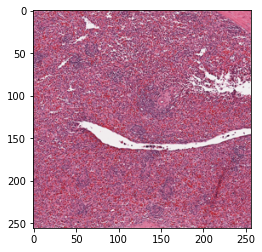

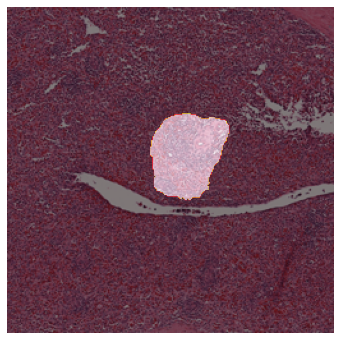

In [4]:
model = load_model("../input/effi4backbone-unetmodel/Effi4backbone_Unetmodel4.h5", compile=False)

sample_test_path = '../input/hubmap-organ-segmentation/test_images/10078.tiff'
image, original_shape = preprocess_image(sample_test_path)
image = image.astype('float64')
plt.imshow(image)

print(original_shape)
print(image.shape, image.shape, image.dtype, image.dtype, np.amin(image), np.amax(image), np.amin(image), np.amax(image))

threshold = 0.2

pred = model.predict(np.expand_dims(image, axis=0))
pred_mask = np.where(pred > threshold, 1, 0)[0]
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(image)
plt.imshow(pred_mask, cmap='hot', alpha=0.5)

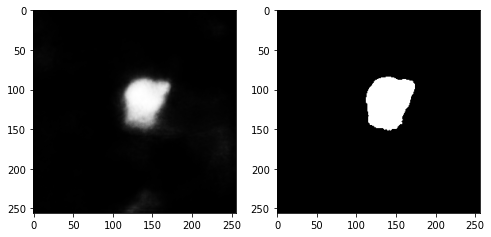

In [5]:
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(1, 2, 1)
plt.imshow(pred[0], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.show()

In [6]:
threshold = 0.2

test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
test_ids = test_df['id']
test_dir = '../input/hubmap-organ-segmentation/test_images'

model = load_model("../input/effi4backbone-unetmodel/Effi4backbone_Unetmodel4.h5", compile=False)

ids = []
rles = []
for id in test_ids:
    path = os.path.join(test_dir, f"{id}.tiff")
    image, original_shape = preprocess_image(path)
    pred = model.predict(np.expand_dims(image, axis=0))
    pred_mask = np.where(pred > threshold, 1, 0)[0]
#     print(pred_mask.shape, pred_mask.shape, pred_mask.dtype, pred_mask.dtype, np.amin(pred_mask), np.amax(pred_mask), np.amin(pred_mask), np.amax(pred_mask))
    resized_pred_mask = keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)
    resized_pred_mask_array = keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    rle = rle_encode(resized_pred_mask_array)
    ids.append(id)
    rles.append(rle)
    
submission_df = pd.DataFrame({'id':ids,'rle':rles})
submission_df.to_csv('submission.csv', index=False)
submission_df

,id,rle
0,10078,1791225 56 1793248 56 1795271 56 1797294 56 17...


# **Add 5 mask**

In [7]:
# # kidney prostate largeintestine spleen
# path_models = ['../input/final-5class/Effi4_kidney.h5', '../input/final-5class/Effi4_prostate.h5', '../input/final-5class/Effi4_largeintestine.h5', '../input/final-5class/Effi4_spleen.h5']
# thresholds = [0.01, 0.1, 0.03, 0.6]

# sample_test_path = '../input/hubmap-organ-segmentation/test_images/10078.tiff'


# abc = np.zeros((1,img_size, img_size, 1))
# image_final = np.zeros((img_size, img_size, 1)).astype('int8')

# image, original_shape = preprocess_image(sample_test_path)
# image = image.astype('float64')

# for i in range(4):
#     pred_, pred_mask_ = predict(path_models[i],image, thresholds[i])
#     abc = np.add(abc, pred_)
# #     image_final = (image_final != pred_mask_).astype('int8')
#     image_final = np.add(image_final, pred_mask_).astype('int8')
    
# image_final = np.where(image_final > 0, 1, 0)
# print(image_final.shape, image_final.shape, image_final.dtype, image_final.dtype, np.amin(image_final), np.amax(image_final), np.amin(image_final), np.amax(image_final))

# fig = plt.figure(figsize=(8, 8))
# columns = 2
# rows = 1
# fig.add_subplot(1, 2, 1)
# plt.imshow(abc[0], cmap='gray')
# fig.add_subplot(1, 2, 2)
# plt.imshow(image_final, cmap='gray')
# plt.show()

In [8]:
# test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
# test_ids = test_df['id']
# test_dir = '../input/hubmap-organ-segmentation/test_images'

# path_models = ['../input/final-5class/Effi4_kidney.h5', '../input/final-5class/Effi4_prostate.h5', '../input/final-5class/Effi4_largeintestine.h5', '../input/final-5class/Effi4_spleen.h5']
# thresholds = [0.01, 0.1, 0.03, 0.6]

# ids = []
# rles = []
# for id in test_ids:
#     image_final = np.zeros((img_size, img_size, 1)).astype('int8')
#     path = os.path.join(test_dir, f"{id}.tiff")
#     image, original_shape = preprocess_image(path)
    
#     for i in range(4):
#         _, pred_mask = predict(path_models[i],image, thresholds[i])
#         image_final = np.add(image_final, pred_mask).astype('int8')
#     image_final = np.where(image_final > 0, 1, 0)
    
#     resized_pred_mask = keras.utils.array_to_img(image_final, scale=False).resize((original_shape[0], original_shape[1]), resample=0)
#     resized_pred_mask_array = keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
#     rle = rle_encode(resized_pred_mask_array)
#     ids.append(id)
#     rles.append(rle)
    
# submission_df = pd.DataFrame({'id':ids,'rle':rles})
# submission_df.to_csv('submission.csv', index=False)
# submission_df

In [9]:
# print(image_final.shape, image_final.shape, image_final.dtype, image_final.dtype, np.amin(image_final), np.amax(image_final), np.amin(image_final), np.amax(image_final))
# plt.imshow(image_final, cmap='gray')
# plt.show()